## Enriching NCAATourneyDetailedResults.csv with Advanced Stats

#### If the opponents of a team score only 75.2 points on average, it could be more about the pace at which the team played instead of their skill on the defensive end. 

### The given Box score numbers are an incomplete standard of a team's performance. 

**Advanced Metrics ** in basketball provide a deeper understanding of a team's performance.

**Possession** is used to normalize basketball statistics - offensive/defensive efficiency and other metrics are all based on how the possession is calculated. Team performance should be measured on a per-possession basis.  

> Possession =0.96*[(Field Goal Attempts)+(Turnovers)+0.44*(Free Throw Attempts)-(Off.Rebounds)]


##### (Notice: Possession values are not calculated by using Play-By-Play data, as it seems like they do not necessarily add up to the final stats of the game and an estimation will do just fine)

For more information [click here](https://www.nbastuffer.com/analytics101/possession/)

### Now let's add some new features that can acutally be used for predictive modelling and ranking a team.


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from math import pi
import os
import xlsxwriter



df = pd.read_csv('../input/NCAATourneyDetailedResults.csv')

#Points Winning/Losing Team
df['WPts'] = df.apply(lambda row: 2*row.WFGM + 3*row.WFGM3 + row.WFTM, axis=1)
df['LPts'] = df.apply(lambda row: 2*row.LFGM + 3*row.LFGM3 + row.LFTM, axis=1)

#Calculate Winning/losing Team Possesion Feature
wPos = df.apply(lambda row: 0.96*(row.WFGA + row.WTO + 0.44*row.WFTA - row.WOR), axis=1)
lPos = df.apply(lambda row: 0.96*(row.LFGA + row.LTO + 0.44*row.LFTA - row.LOR), axis=1)
#two teams use almost the same number of possessions in a game
#(plus/minus one or two - depending on how quarters end)
#so let's just take the average
df['Pos'] = (wPos+lPos)/2
df['WPos'] = wPos
df['LPos'] = lPos

### Advanced Metrics

In [13]:
#Offensive efficiency (OffRtg) = 100 x (Points / Possessions)
df['WOffRtg'] = df.apply(lambda row: 100 * (row.WPts / row.WPos), axis=1)
df['LOffRtg'] = df.apply(lambda row: 100 * (row.LPts / row.LPos), axis=1)
#Defensive efficiency (DefRtg) = 100 x (Opponent points / Opponent possessions)
df['WDefRtg'] = df.LOffRtg
df['LDefRtg'] = df.WOffRtg
#Net Rating = Off.Rtg - Def.Rtg
df['WNetRtg'] = df.apply(lambda row:(row.WOffRtg - row.WDefRtg), axis=1)
df['LNetRtg'] = df.apply(lambda row:(row.LOffRtg - row.LDefRtg), axis=1)
                         
#Assist Ratio : Percentage of team possessions that end in assists
df['WAstR'] = df.apply(lambda row: 100 * row.WAst / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
df['LAstR'] = df.apply(lambda row: 100 * row.LAst / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)
#Turnover Ratio: Number of turnovers of a team per 100 possessions used.
#(TO * 100) / (FGA + (FTA * 0.44) + AST + TO)
df['WTOR'] = df.apply(lambda row: 100 * row.WTO / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
df['LTOR'] = df.apply(lambda row: 100 * row.LTO / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)
                    
#The Shooting Percentage : Measure of Shooting Efficiency (FGA/FGA3, FTA)
df['WTSP'] = df.apply(lambda row: 100 * row.WPts / (2 * (row.WFGA + 0.44 * row.WFTA)), axis=1)
df['LTSP'] = df.apply(lambda row: 100 * row.LPts / (2 * (row.LFGA + 0.44 * row.LFTA)), axis=1)
#eFG% : Effective Field Goal Percentage adjusting for the fact that 3pt shots are more valuable 
df['WeFGP'] = df.apply(lambda row:(row.WFGM + 0.5 * row.WFGM3) / row.WFGA, axis=1)      
df['LeFGP'] = df.apply(lambda row:(row.LFGM + 0.5 * row.LFGM3) / row.LFGA, axis=1)   
#FTA Rate : How good a team is at drawing fouls.
df['WFTAR'] = df.apply(lambda row: row.WFTA / row.WFGA, axis=1)
df['LFTAR'] = df.apply(lambda row: row.LFTA / row.LFGA, axis=1)
                         
#OREB% : Percentage of team offensive rebounds
df['WORP'] = df.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
df['LORP'] = df.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)
#DREB% : Percentage of team defensive rebounds
df['WDRP'] = df.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
df['LDRP'] = df.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)                                      
#REB% : Percentage of team total rebounds
df['WRP'] = df.apply(lambda row: (row.WDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)
df['LRP'] = df.apply(lambda row: (row.LDR + row.LOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1) 


#### PIE : Measure of a team's performance

> *A high PIE % is highly correlated to winning. In fact, a team’s PIE rating and a team’s winning percentage correlate at an R square of .908 which indicates a "strong" correlation*

from the official site of the [NBA](https://stats.nba.com/help/glossary/)

In [14]:
wtmp = df.apply(lambda row: row.WPts + row.WFGM + row.WFTM - row.WFGA - row.WFTA + row.WDR + 0.5*row.WOR + row.WAst +row.WStl + 0.5*row.WBlk - row.WPF - row.WTO, axis=1)
ltmp = df.apply(lambda row: row.LPts + row.LFGM + row.LFTM - row.LFGA - row.LFTA + row.LDR + 0.5*row.LOR + row.LAst +row.LStl + 0.5*row.LBlk - row.LPF - row.LTO, axis=1) 
df['WPIE'] = wtmp/(wtmp + ltmp)
df['LPIE'] = ltmp/(wtmp + ltmp)

In [15]:
#categories need to be normalized for a sensible plot
categories= ['FTAR','ORP','DRP','PIE','eFGP']

#get stats by TeamID
#TODO: filter by season
def get_stats(teamid, categories):
    
    wstats = []
    wteam = df.loc[(df['WTeamID'] == teamid)]
    for i in categories:
        wstats.append(wteam['W'+i].sum())
    
    lstats = []
    lteam = df.loc[(df['LTeamID'] == teamid)]
    for i in categories:
        lstats.append(lteam['L'+i].sum())

    return [(i+j)/(len(wteam.index)+len(lteam.index))
            for i,j in zip(wstats,lstats)]

#plotting advanced stats for given team
def plot_team(stats, categories):

    stats += stats[:1]

    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)

    plt.xticks(angles[:-1], categories, color='grey', size=10)

    ax.set_rlabel_position(0)
    plt.yticks([i*0.1 for i in range(10)], [], color="black", size=8)
    plt.ylim(0,1)
    
    ax.plot(angles, stats, linewidth=2, linestyle='solid')
    ax.fill(angles, stats, 'b', alpha=0.2)

#### Evaluations of random NCAA teams (TODO: filtered by year)
##### Note: to plot different metrics, values need to be normalized first.

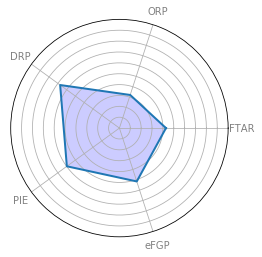

In [16]:
plot_team(get_stats(1181,categories),categories)

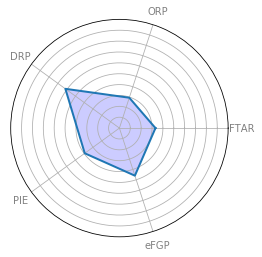

In [17]:
plot_team(get_stats(1421,categories),categories)

In [18]:
#let's call it dimensionality reduction
# --> build your predictive model on advanced stats only
#df.drop(['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'], axis=1, inplace=True)
#df.drop(['LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'], axis=1, inplace=True)

#TODO: Compute Avanced Stats for entire Season for each Team
#df['WPIE'].groupby([df['Season'], df['WTeamID']]).describe()

df.to_csv('NCAASeasonDetailedResultsEnriched.csv', index=False)
print(df)


      Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  \
0       2003     134     1421      92     1411      84    N      1    32   
1       2003     136     1112      80     1436      51    N      0    31   
2       2003     136     1113      84     1272      71    N      0    31   
3       2003     136     1141      79     1166      73    N      0    29   
4       2003     136     1143      76     1301      74    N      1    27   
5       2003     136     1163      58     1140      53    N      0    17   
6       2003     136     1181      67     1161      57    N      0    19   
7       2003     136     1211      74     1153      69    N      0    20   
8       2003     136     1228      65     1443      60    N      0    24   
9       2003     136     1242      64     1429      61    N      0    28   
10      2003     136     1266      72     1221      68    N      0    22   
11      2003     136     1281      72     1356      71    N      0    28   
12      2003